In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
from general_utils import rank_and_bin
from plot_utils import plot_and_compare_results

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

https://www.nature.com/articles/nature21065

"All liver zonation profiles previously described were monotonically increasing or decreasing porto–centrally. Our high spatial resolution enabled identification of a new class of non-monotonic zonation profiles that peak at intermediate lobule layers (Figs. 3c, 4a, Extended Data Figs 5, 10). Although there was no significant gene ontology annotation associated with these genes, they included key liver genes such as Hamp and Hamp2 that encode hepcidin, a secreted liver hormone that regulates systemic iron levels (Fig. 4a). Additional non-monotonic genes included Igfbp2, Mup3 and Cyp8b1 (Fig. 3c, Extended Data Figs 5, 10). The non-monotonic expression of these genes could not be explained by the previously identified non-monotonic pattern of liver polyploidy25 (Extended Data Fig. 10e, Methods)."

### Load the ground-truth and evaluate the methods

In [3]:
logger.setLevel(logging.DEBUG)
from liver_info import load_processsed_hepatocyte_data, load_zonation_result, get_known_liver_markers
dat_dir = "/Users/jjzhu/Google Drive/_GLISS/data/liver2k"
fdir = '/Users/jjzhu/Google Drive/_GLISS/spatial_subplots/'
zone_vals = load_zonation_result(dat_dir, just_vals=True)
main_dir = os.path.join(dat_dir, "analysis_on_data_original")
lm_genes = get_known_liver_markers()["zonation"]
report_genes = ["Hamp", "Hamp2", "Igfbp2", "Mup3", "Cyp8b1"]
x_k, x_d, obs_df, var_df = load_processsed_hepatocyte_data(main_dir, center=False, scale=False)

[feat_viz INFO] Data directory: /Users/jjzhu/Google Drive/_GLISS/data/liver2k/analysis_on_data_original/data
[feat_viz INFO] Loaded data: x (1415, 6) and y (1415, 8883)


### Load the results prescribed method (ran below)

In [4]:
from io_utils import load_all_pipeline_results
RDIR = "/Users/jjzhu/Google Drive/_GLISS/data/analysis_050719"
pipe_res, all_lams = load_all_pipeline_results(RDIR)
all_lams["smFISH"] = zone_vals
# vanilla: our proposed approach
# oracle: approach using the zones from the original study
# graph: our proposed approach
# pc: the linear PC equivalent approach
# hybrid: using the 1-PC to construct the graph
mopts = ["graph", "pc", "hybrid"]
mtypes = ["vanilla", "oracle"]
for method in mopts:
    for mtype in mtypes:
        key = "{}_{}".format(method, mtype)
        result = pipe_res[key] 
        for lam_t in ["lam_init", "lam_update"]:
            name = "{}_{}".format(key, lam_t)
            all_lams[name] = result[lam_t]
# load additional results
# palantir, paga: trajectory inferece using all genes
# add the other benchmark methods
mdir = '/Users/jjzhu/Google Drive/_GLISS/data/analysis_060719/hepa_data/ti_methods'
names = ['palantir', 'paga']
for name in names:
    fn = os.path.join(mdir, '{}_obs_df.csv'.format(name))
    df = pd.read_csv(fn)
    df = df.set_index('cell_id')
    df = df.loc[obs_df.index]
    all_lams[name] = df['pseudotime']                 
lam_df = pd.DataFrame(all_lams)
# manually switch signs for absolute correlation
switch_signs = ["graph_vanilla_lam_init", 
                "graph_vanilla_lam_update",
                "pc_vanilla_lam_update",
                "unsup_pc"]
for var in switch_signs:
    lam_df[var] = - lam_df[var]
    
display(lam_df.head())

,unsup_graph,unsup_pc,smFISH,graph_vanilla_lam_init,graph_vanilla_lam_update,graph_oracle_lam_init,graph_oracle_lam_update,pc_vanilla_lam_init,pc_vanilla_lam_update,pc_oracle_lam_init,pc_oracle_lam_update,hybrid_vanilla_lam_init,hybrid_vanilla_lam_update,hybrid_oracle_lam_init,hybrid_oracle_lam_update,palantir,paga
Cell1,0.017049,4.522994,3,0.010613,0.022753,0.000000e+00,0.017010,-0.568632,4.772119,3,-5.690150,-0.568632,0.019459,3,0.017010,0.682967,0.600050
Cell2,0.011912,-9.614326,7,0.029973,0.022153,-9.228443e-18,0.021553,1.708969,4.174905,7,-2.988103,1.708969,0.024558,7,0.021553,0.768242,0.621814
Cell3,0.019878,-1.569353,7,0.026740,0.024046,8.584734e-17,0.025185,1.278176,5.743204,7,-4.696668,1.278176,0.027853,7,0.025185,0.781591,0.678568
Cell4,0.021721,1.490624,7,0.031416,0.018866,-9.686125e-18,0.020967,2.060846,7.690742,7,-7.256610,2.060846,0.023694,7,0.020967,0.768702,0.654502
Cell5,0.013850,-7.101352,4,-0.029628,-0.054783,-1.450494e-17,-0.044778,-1.024459,-12.230676,4,12.133470,-1.024459,-0.038515,4,-0.044778,0.137123,0.229735


### Plot pairwise correlations with lambdas of interest

,$\pi^\mathtt{B}$,$\pi^\mathtt{G}$,$\xi^\mathtt{G}$,$\omega^\mathtt{1}$,$\omega^\mathtt{2}$
Cell1,3,0.010613,0.022753,0.682967,0.600050
Cell2,7,0.029973,0.022153,0.768242,0.621814
Cell3,7,0.026740,0.024046,0.781591,0.678568
Cell4,7,0.031416,0.018866,0.768702,0.654502
Cell5,4,-0.029628,-0.054783,0.137123,0.229735


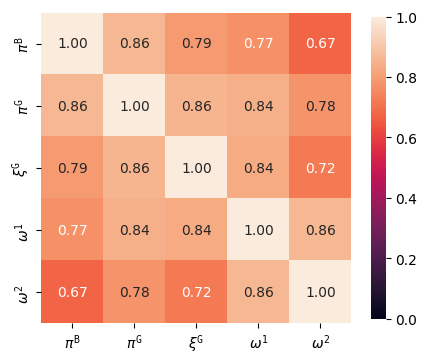

In [5]:
from plot_utils import plot_corr_mtx

# select and rename here
select_vars = {
    "smFISH": r"$\pi^\mathtt{B}$",
    "graph_vanilla_lam_init": r"$\pi^\mathtt{G}$",
#     "pc_vanilla_lam_init": r"$\pi^\mathtt{P}$",
    "graph_vanilla_lam_update": r"$\xi^\mathtt{G}$",
#     "pc_vanilla_lam_update": r"$\xi^\mathtt{P}$",
#     "unsup_graph": r"$\omega^\mathtt{G}$",
#     "unsup_pc": r"$\omega^\mathtt{P}$",
    "palantir": r"$\omega^\mathtt{1}$",
    "paga" : r"$\omega^\mathtt{2}$"
}
sub_df = lam_df[list(select_vars.keys())]
sub_df = sub_df.rename(index=str, columns=select_vars)
display(sub_df.head())
plot_corr_mtx(sub_df, fn=None)

### Customized Figure

[feat_viz INFO] Saved figure to: /Users/jjzhu/Google Drive/_GLISS/spatial_subplots/hepa_lambda_heatmap.pdf


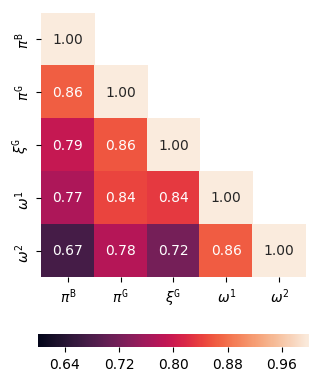

In [6]:
fn = fdir + 'hepa_lambda_heatmap.pdf'
show_cbar = True
vmin=0.6
vmax=1
corr_df = sub_df.corr('spearman')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask, k=1)] = True
sns.heatmap(corr_df, annot=True, fmt=".2f", square=True, ax=ax,
                cbar=show_cbar, vmin=vmin, vmax=vmax, mask=mask,
                cbar_kws = dict(shrink=0.7,use_gridspec=False,location="bottom"))
plt.savefig(fn, bbox_inches='tight', transparent=True) 
logger.info("Saved figure to: {}".format(fn))
plt.show()

### Search for p-values of known genes

In [7]:
from main_methods import setup_cmp_df
from liver_info import get_known_liver_markers, get_marker_color_dict
from plot_utils import create_color_map, plot_full_pattern
from matplotlib.ticker import FormatStrFormatter
from plot_utils import update_boxplot_cols

def get_unique_rejection_df(res_dict, var_df):
    pval_df, pval_thres, cmp_sets, mets = setup_cmp_df(res_dict)
    pval_df = pd.concat([var_df.reset_index(drop=True), pval_df], axis=1)
    df_list = []
    for i in range(2):
        j = 1 * (i == 0)
        sub_df = pval_df.loc[pval_df[mets[i]] <= pval_thres[i]]
        sub_df = sub_df.loc[sub_df[mets[j]] > pval_thres[j]]
        sub_df["exclusive_rejection"] = mets[i]
        logger.info("Set selection: {}".format(sub_df.shape)) 
        sub_df = sub_df.set_index("gene_ids")
        sub_df = sub_df.sort_values([mets[i], mets[j]], ascending=[1, 0])
#         sub_df = sub_df.sort_values([mets[i], "std"], ascending=[1, 0])
        df_list.append(sub_df)
    df_comp = pd.concat(df_list, axis=0) # should never conflict
    df_dict = dict(zip(mets, df_list))
    return df_dict, df_comp

def parse_exlusive_genes():
    mets = list(res_dict.keys())
    use_lam = (lam_in is not None)
    for i in range(2):
        j = 1 * (i == 0)
        sub_df = df_comp.sort_values([mets[i], mets[j]], ascending=[1, 0])
        sub_df = sub_df.head(disp_genes)
        display(sub_df)
        plt_idx = list(sub_df.index)
        plt_genes = list(sub_df.loc[plt_idx]["gene_ids"])
        if not use_lam:
            lam_in = res_dict[mets[i]]["lam_init"]
        if cat_avg:
            lam_in = rank_and_bin(lam_in, n_bins=9)                
        plot_gene_profile(lam_in, x_d[:, plt_idx], plt_genes, cat_avg=cat_avg)
        
def report_gene_info(report_genes, unique_df):
    for gene in report_genes:
        if gene in unique_df.index:
            gene_info = unique_df.loc[gene]
            logger.info("{} only rejected by {}".format(gene, gene_info["exclusive_rejection"]))
    display(pval_df[pval_df["gene_ids"].isin(report_genes)])
    

def plot_gene_expr_comp(lam_df, x_d, genes, methods, horizontal=False, fn=None):
    fontsize=23
    labels = list(lam_df["smFISH"])
    if len(genes) == 1 and len(methods) == 1:
        fig, axes = plt.subplots(1, 1, figsize=(5, 4))
    else:
        if horizontal:
            fig, axes = plt.subplots(len(methods), len(genes), 
                                 figsize=(2.3*len(genes), 2*len(methods)))
        else:
            fig, axes = plt.subplots(len(genes), len(methods), 
                                 figsize=(1.85*len(methods),1.9*len(genes)),
                                 sharex="col", sharey="row")
    
    for i, gene in enumerate(genes):
        gid = var_df.index.get_loc(gene)
        for j, method in enumerate(methods):
            if len(genes) == 1 and len(methods) == 1:
                ax = axes
                add_cbar = True
            else:
                add_cbar = False
                if len(genes) == 1:
                    ax = axes[j]
                elif len(methods) == 1:
                    ax = axes[i]
                else:        
                    if horizontal:
                        ax = axes[j, i]
                    else:
                        ax = axes[i, j]
            order_only = (method != "smFISH")
            plot_full_pattern(ax, lam_df[method], x_d[:,gid], 
                              order_only=order_only,
                              add_color_bar=add_cbar, labels=labels)    
            if horizontal:
                ax.set_xlabel(None)
                fig.subplots_adjust(hspace=0.5, wspace=0.42)
                ax.set_ylabel(gene, labelpad=0, fontsize=fontsize)
                if len(methods) > 1:
                    ax.set_title(select_vars[method])    
            else:
                if j == 0:
                    ax.set_ylabel(gene, fontsize=fontsize,  style='italic')
                if i == (len(genes) -1):
                    ax.set_xlabel(select_vars[method], fontsize=fontsize)
                fig.subplots_adjust(hspace=0, wspace=0)
            
            ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
            ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
            ax.tick_params(axis='both', which='major', pad=2, labelsize=fontsize-5)
            if method == "smFISH":
                xticks = [1,3, 5, 7, 9]
            else:
                xticks = [0, 1000]
            if gene == "Malat1":
                ax.set_ylim(-0.5, 3)
                ax.set_yticks(ticks=[0, 1, 2])  
            ax.set_xticks(ticks=xticks)    
    if fn:
        plt.savefig(fn, bbox_inches='tight', transparent=True, dpi=100) 
        logger.info("Saved figure to: {}".format(fn))
    plt.show()
    

def contrast_methods_gene(res_dict, var_df, x_d, lam_in=None, disp_genes=8):
    pval_df, pval_thres, cmp_sets, mets = setup_cmp_df(res_dict)
    var_df = var_df.reset_index(drop=True)
    pval_df = pd.concat([var_df, pval_df], axis=1)
    logger.info("Merged df: {}".format(pval_df.shape))    
    union_idx = set.union(*cmp_sets)
    df_comp = get_unique_rejection_df(res_dict, var_df)
    use_lam = (lam_in is not None)
    for i in range(2):
        j = 1 * (i == 0)
        sub_df = df_comp.sort_values([mets[i], mets[j]], ascending=[1, 0])
        sub_df = sub_df.head(disp_genes)
        display(sub_df)
        plt_idx = list(sub_df.index)
        fig, axes = plt.subplots(1, len(plt_idx), figsize=(len(plt_idx)*3, 3))
        if not use_lam:
            lam_in = res_dict[mets[i]]["lam_init"]
        for i_g, g_idx in enumerate(plt_idx):
            ax = axes[i_g]
            ax.scatter(lam_in, x_d[:, g_idx], s=5)
            ax.set_title(sub_df.loc[g_idx]["gene_ids"])
        plt.show()
        
def plot_contrast_rejections(res_dict, var_df, plain=False, fn=None):
    fontsize=15
    my_pal = {"pc_vanilla": "red", "graph_vanilla":"blue"}
    _, df_comp = get_unique_rejection_df(res_dict, var_df)
    plt_vars = ['sparsity', 'cv']
    fig, axes = plt.subplots(1, len(plt_vars), figsize=(len(plt_vars)*2.7, 3))
    for i_plt, var in enumerate(plt_vars):
        ax = axes[i_plt]
        

        sns.boxplot(x="exclusive_rejection", y=var, 
                    data=df_comp, ax=ax, 
#                     order=["graph_vanilla", "pc_vanilla"],
                    palette="Set1",
                    width=0.5, fliersize=1)
        ax.set_title(var)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='gray', linestyle='dashed')
        update_boxplot_cols(ax)
        if plain:
            ax.set_title(None)
            ax.set_xticks([])
            ax.tick_params(axis='both', which='major', pad=2, labelsize=fontsize)
    plt.tight_layout()
    if fn:
        plt.savefig(fn, bbox_inches='tight', transparent=True) 
        logger.info("Saved figure to: {}".format(fn))
    plt.show()

In [8]:
var_df.head()

,gene_ids,n_cells,mean,std,npc
0610007C21Rik;Apr3,0610007C21Rik;Apr3,770,0.487967,0.527124,770
0610007L01Rik,0610007L01Rik,761,0.455494,0.506628,761
0610007P08Rik;Rad26l,0610007P08Rik;Rad26l,65,0.030682,0.159816,65
0610007P14Rik,0610007P14Rik,749,0.456374,0.518156,749
0610007P22Rik,0610007P22Rik,35,0.015438,0.107326,35


In [9]:
key = 'graph_vanilla'
var_df['pvals'] = pipe_res[key]['p_vals']
rej_vec = np.repeat(False, var_df.shape[0])
rej_vec[pipe_res[key]['rejections']] = True
var_df['rejects'] = rej_vec

In [10]:
print('Number of SV genes: {}'.format(len(pipe_res[key]['rejections'])))
display(var_df.loc[lm_genes])
display(var_df.loc[report_genes])

Number of SV genes: 1483


,gene_ids,n_cells,mean,std,npc,pvals,rejects
Cyp2e1,Cyp2e1,1221,3.086100,2.132811,1221,0.0001,True
Cyp2f2,Cyp2f2,1235,2.269190,1.415569,1235,0.0001,True
Alb,Alb,1415,6.190163,0.610225,1415,0.0001,True
Ass1,Ass1,1411,3.164296,0.588850,1411,0.0001,True
Asl,Asl,1397,2.707551,0.570133,1397,0.0001,True
Glul,Glul,523,0.347392,0.661617,523,0.0001,True


,gene_ids,n_cells,mean,std,npc,pvals,rejects
Hamp,Hamp,1327,2.937353,1.240587,1327,0.0001,True
Hamp2,Hamp2,1158,1.595090,1.069451,1158,0.0001,True
Igfbp2,Igfbp2,1257,1.622701,0.830093,1257,0.0001,True
Mup3,Mup3,1366,2.975959,1.237950,1366,0.0001,True
Cyp8b1,Cyp8b1,1315,1.913578,0.753823,1315,0.0001,True


[feat_viz INFO] Saved figure to: /Users/jjzhu/Google Drive/_GLISS/spatial_subplots/hepa_scatter_lm_genes.png


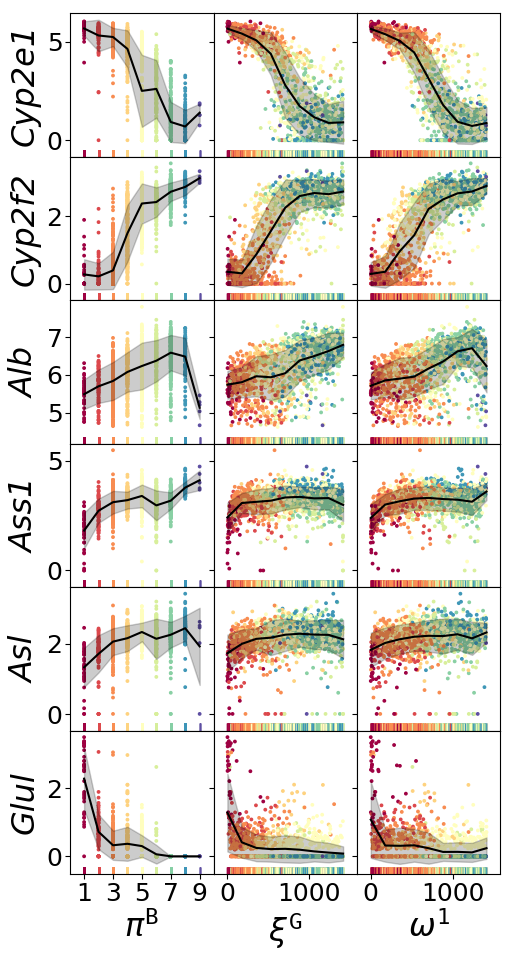

In [11]:
methods = ["smFISH",
#            "graph_vanilla_lam_init", 
           "graph_vanilla_lam_update", 
#            "paga",
           "palantir"]
fn = fdir + 'hepa_scatter_lm_genes.png'
plot_gene_expr_comp(lam_df, x_d, lm_genes, methods, fn=fn)

[feat_viz INFO] Saved figure to: /Users/jjzhu/Google Drive/_GLISS/spatial_subplots/hepa_scatter_report_genes.png


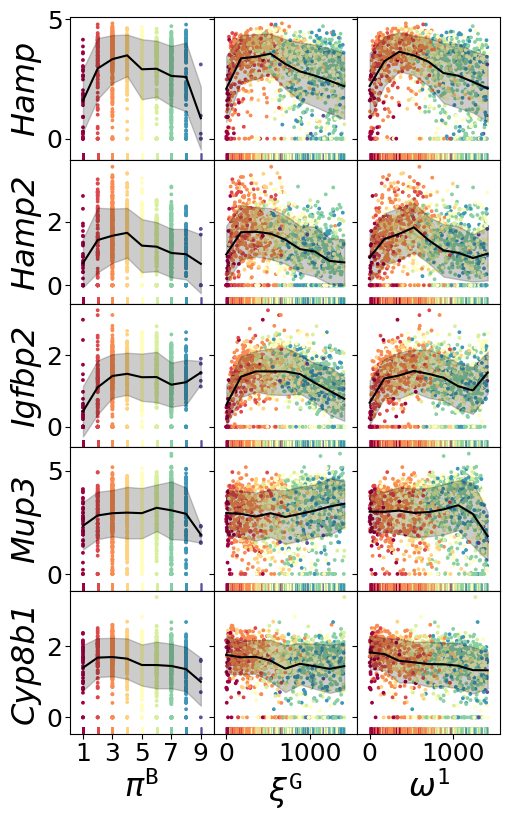

In [12]:
fn = fdir + 'hepa_scatter_report_genes.png'
plot_gene_expr_comp(lam_df, x_d, report_genes, methods, fn=fn)

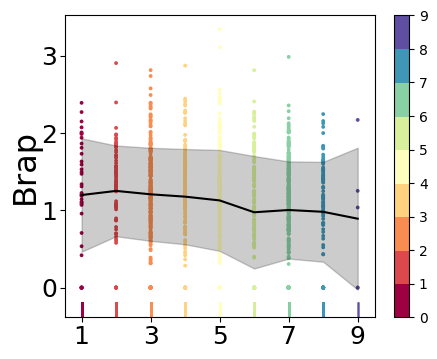

In [13]:
# example of a single gene and a single method
plot_gene_expr_comp(lam_df, x_d, ["Brap"], ["smFISH"], horizontal=True)